<a href="https://colab.research.google.com/github/lobabacar/test_git/blob/main/Notebook_2_flash_examples_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 🎯 Objectives

⚠**Note**: this notebook is an attempt to make [this script](https://colab.research.google.com/drive/12js_YhnKMghNTZtjIM8Mvm_AzUqKPLqY?usp=sharing) work with the last version of Flash

This notebook is derived from Mort Canty's [Notebook](https://gist.github.com/mortcanty/ac4c48e3d10e89676b7fe9b3a6f1ba3a):

­­*In this notebook we examine a popular FCN architecture, called [UNet](https://arxiv.org/abs/1505.04597) to perform a specific semantic segmentation task, namely urban building recognition: the identification within an arbitrarily complex remote sensing image of houses, schools, commercial edifices, etc. Here for example is a recent application of the UNet architecture for large scale [semantic classification of building footprints](https://arxiv.org/abs/2107.12283) over the entire African continent.*  

*To train our model we can make use of the dataset  for the [Inria Aerial Imaging Labeling Benchmark](https://project.inria.fr/aerialimagelabeling/), published in 2016. The [dataset](https://project.inria.fr/aerialimagelabeling/) consists of 30cm spatial resolution RGB images and semantic labels over built up regions in Europe and USA. A presentation of the most successful semantic classifiers determined in the early part of the benchmark competition is given [here](https://hal.inria.fr/hal-01767807/document).*

*However, we haven't made use of the Inria RGB images themselves, prefering rather to upload only the semantic labels to [Google Earth Engine](https://developers.google.com/earth-engine/) (GEE) and then use them to generate a 1m resolution four-band (RGBN) training dataset from the [NAIP imagery in the GEE high resolution image archive](https://developers.google.com/earth-engine/datasets/tags/highres). With that dataset we can train our UNet semantic classifier. The hope is then to be able apply it to any region covered by the NAIP Program, i.e., anywhere within the continental USA.*

**Goal**:
* Experiment with Flash for semantic segmentation
* Apply semantic segmentation to building footprint


# 1. 🛠 Setup

In [ ]:
!nvidia-smi
!lscpu
! pip list | grep torch

Sat Feb 18 20:23:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We install Flash-lightning:

In [ ]:
%%capture --no-stderr
!pip install 'git+https://github.com/PyTorchLightning/lightning-flash.git@0.8.1#egg=lightning-flash[image]'

In [ ]:
!pip -q install wandb python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.6 MB/s eta 0:00:00


We need to restart the kernel to make sure the libraries are loaded:

In [ ]:
import os
os._exit(00)

In [ ]:
%load_ext autoreload
%autoreload 2

Check that all the python packaged are present:

In [ ]:
! pip list | grep torch
! pip list | grep lightning

In [ ]:
%%capture --no-stderr
!pip3 -q install  rich
from rich import pretty, print, inspect, traceback
from rich.progress import track
pretty.install()

In [ ]:
import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(level= logging.ERROR, format=FORMAT, datefmt="[%X]", handlers=[RichHandler(rich_tracebacks=True)],  # <- not sets rich_tracebacks
)

In [ ]:
%%writefile /usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py
import warnings
from typing import Any

from pytorch_lightning.utilities.rank_zero import LightningDeprecationWarning as NewLightningDeprecationWarning
from pytorch_lightning.utilities.rank_zero import rank_zero_deprecation as new_rank_zero_deprecation
from pytorch_lightning.utilities.rank_zero import rank_zero_warn as new_rank_zero_warn

# enable our warnings
warnings.simplefilter("default", category=NewLightningDeprecationWarning)


class PossibleUserWarning(UserWarning):
    """Warnings that could be false positives."""

class WarningCache(set):
    def warn(self, message: str, stacklevel: int = 5, **kwargs: Any) -> None:
        if message not in self:
            self.add(message)
            new_rank_zero_warn(message, stacklevel=stacklevel, **kwargs)

    def deprecation(self, message: str, stacklevel: int = 5, **kwargs: Any) -> None:
        if message not in self:
            self.add(message)
            new_rank_zero_deprecation(message, stacklevel=stacklevel, **kwargs)

Overwriting /usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py


In [ ]:
import torch
import flash
from flash.core.data.utils import download_data
from flash.image import SemanticSegmentation, SemanticSegmentationData

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(


In [ ]:
from flash.core.data.callback import BaseDataFetcher
from flash.core.data.io.input import DataKeys
from flash.core.data.data_module import DataModule
from flash.core.data.io.input import Input
from flash.core.utilities.imports import _FIFTYONE_AVAILABLE, _IMAGE_EXTRAS_TESTING, _IMAGE_TESTING, lazy_import
from flash.core.utilities.stages import RunningStage
from flash.core.utilities.types import INPUT_TRANSFORM_TYPE
from flash.image.segmentation.input import (
    SemanticSegmentationFiftyOneInput,
    SemanticSegmentationFilesInput,
    SemanticSegmentationFolderInput,
    SemanticSegmentationNumpyInput,
    SemanticSegmentationTensorInput,
)
from flash.image.segmentation.input_transform import SemanticSegmentationInputTransform
from flash.image.segmentation.viz import SegmentationMatplotlibVisualization

# 2. ⬇️ Dataset Download

You can fix the random generator:

In [ ]:
import numpy as np
seed = 100
def set_all_seeds(seed):
  import pytorch_lightning
  pytorch_lightning.seed_everything(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed=seed)
  import random
  random.seed(a=100)
  torch.backends.cudnn.deterministic = True

Once the seed value is set, the random number sequence repeats the random same pattern:

In [ ]:
set_all_seeds(seed)
idx= np.random.permutation(10)
print(print(idx))
assert (idx == np.array([7, 6, 1, 5, 4, 2, 0, 3, 9, 8])).all() == True

INFO:lightning_fabric.utilities.seed:Global seed set to 100


[7 6 1 5 4 2 0 3 9 8]
None


We download the INRIA dataset:

In [ ]:
import gdown
gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=1PRC37iOpISaQln9XWfueZwLa4gqEaMMH",
        '/content/Inria.zip'
    )

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1PRC37iOpISaQln9XWfueZwLa4gqEaMMH
To: /content/Inria.zip
100%|██████████| 1.23G/1.23G [00:07<00:00, 158MB/s]


'/content/Inria.zip'

We unzip the files:

In [ ]:
!unzip -qo Inria.zip

We build a list of files:

In [ ]:
import glob, os
#training files
train_files, train_seg_files= [],[]
for f in glob.glob('/content/content/buildings/train/RGB/*.png'):
  train_files.append(f)
  train_seg_files.append(f.replace('RGB','Seg'))
# Test files
test_files, test_seg_files= [],[]
for f in glob.glob('/content/content/buildings/test/RGB/*.png'):
  test_files.append(f)
  test_seg_files.append(f.replace('RGB','Seg'))
#print(train_seg_files)
train_files= train_files[:1000]
train_seg_files= train_seg_files[:1000]
test_files= test_files[:1000]
test_seg_files= test_seg_files[:1000]

Eventually, you can add some custom data augmentation:

In [ ]:
from flash.core.data.transforms import ApplyToKeys, AlbumentationsAdapter #, KorniaParallelTransforms
import albumentations as alb
from dataclasses import dataclass
from typing import Any, Callable, Dict, Tuple
from torchvision import transforms as T

def my_permute_target(sample: Dict[str, Any]) -> Dict[str, Any]:
    #if DataKeys.TARGET in sample:
    target = sample[DataKeys.TARGET]
    print(target.shape)
        #if target.ndim == 2:
        #    target = target[None, :, :]
        #sample[DataKeys.TARGET] = target#.transpose((1, 2, 0))
        #sample[DataKeys.TARGET] = target.squeeze(1)
    return sample

def my_prepare_target(tensor: torch.Tensor) -> torch.Tensor:
    """Convert the target mask to long and remove the channel dimension."""
    return tensor.long().squeeze(1)

@dataclass
class MySemanticSegmentationInputTransform(SemanticSegmentationInputTransform):

    image_size: Tuple[int, int] = (256, 256)
    def train_per_sample_transform2(self) -> Callable:
        return T.Compose(
            [
                my_permute_target,
                #AlbumentationsAdapter(
                #    [
                #        alb.Resize(*self.image_size),
                #        alb.HorizontalFlip(p=0.5),
                #        #alb.Normalize(mean=self.mean, std=self.std),
                #    ]
                #),
                ApplyToKeys(
                    DataKeys.INPUT,
                    T.ToTensor(),
                ),
            ]
        )
    def train_per_sample_transform(self) -> Callable:
        return ApplyToKeys(
            [DataKeys.INPUT, DataKeys.TARGET],
            AlbumentationsAdapter(
                    [
                        alb.Resize(*self.image_size),
                        alb.HorizontalFlip(p=0.5),
                        alb.Normalize(mean=self.mean, std=self.std),
                    ]
            ),
        )


In [ ]:
import inspect
inspect.getfullargspec(SemanticSegmentationData.from_files).args

['cls',
 'train_files',
 'train_targets',
 'val_files',
 'val_targets',
 'test_files',
 'test_targets',
 'predict_files',
 'input_cls',
 'num_classes',
 'labels_map',
 'transform',
 'transform_kwargs']

In [ ]:
datamodule = SemanticSegmentationData.from_files(
    train_files=train_files,
    train_targets=train_seg_files,
    test_files=test_files,
    test_targets=test_seg_files,
    val_split=0.1,
    #transform= MySemanticSegmentationInputTransform,
    transform_kwargs=dict(image_size=(256, 256)),
    num_classes=2,
    num_workers=2,
    batch_size=8,
    pin_memory=True,
)

In [ ]:
datamodule = SemanticSegmentationData.from_folders(
    train_folder="/content/content/buildings/train/RGB",
    train_target_folder="/content/content/buildings/train/Seg",
    test_folder="/content/content/buildings/test/RGB",
    test_target_folder="/content/content/buildings/test/Seg",
    val_split=0.1,
    transform= MySemanticSegmentationInputTransform,
    #transform_kwargs=dict(image_size=(256, 256)),
    num_classes=2,
    num_workers=2,
    batch_size=8,
)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Please pass an instantiated object of the `InputTransform` class. Passing the Class and keyword arguments separately has been deprecated since v0.8.0 and will be removed in v0.9.0.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


check training data:

2.6399999
(256, 256)
1
2.6399999
(256, 256)
1
2.6399999
(256, 256)
0
2.6399999
(256, 256)
1


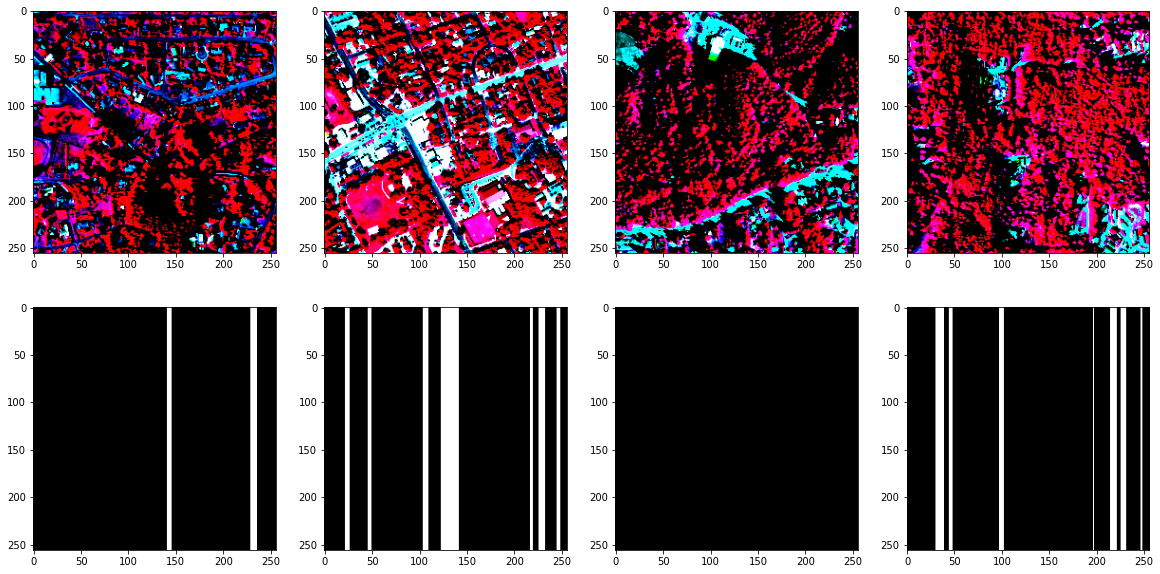

In [ ]:
data = next(iter(datamodule.train_dataloader()))
imgs, labels = data[DataKeys.INPUT], data[DataKeys.TARGET]
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 4, figsize = (20,10))
for i in range(min(4,imgs.shape[0])):
    input = imgs[i].numpy().transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
    print(np.max(input))
    #print(input.shape)
    ax[0,i].imshow(input)
    seg = labels[i].numpy()
    print(seg.shape)
    print(np.max(seg))
    ax[1,i].imshow(seg, cmap = plt.cm.gray)
    #ax[1,i].imshow(np.reshape(seg.squeeze(), (256,256)), cmap = plt.cm.gray)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

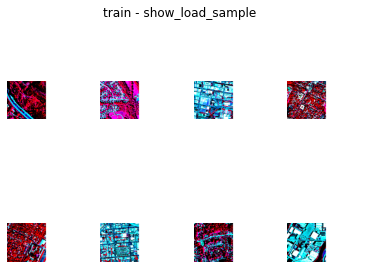

In [ ]:
# 2.2 Visualise the samples
from flash.image.segmentation.output import SegmentationLabelsOutput

labels_map = SegmentationLabelsOutput.create_random_labels_map(num_classes=2)
out= SegmentationLabelsOutput(labels_map, visualize= True)

#datamodule.set_labels_map(labels_map)
datamodule.show_train_batch("load_sample")
#datamodule.show_train_batch("post_tensor_transform")

# 3. 🧠 Neural Network
We can check what kind of architectures are available.

* Backbones (encoder):

In [ ]:
from flash.image import SemanticSegmentation
print(SemanticSegmentation.available_backbones('fpn'))
# ['densenet121', ..., 'xception'] # + 113 models

* Heads (decoder):

In [ ]:
from flash.image import SemanticSegmentation
print(SemanticSegmentation.available_heads())
# ['deeplabv3', 'deeplabv3plus', 'fpn', ..., 'unetplusplus']

[
    'deeplabv3',
    'deeplabv3plus',
    'fpn',
    'linknet',
    'manet',
    'pan',
    'pspnet',
    'unet',
    'unetplusplus'
]

* Available pretraining:

In [ ]:
print(SemanticSegmentation.available_pretrained_weights('resnet18'))
# ['imagenet', 'advprop']

['imagenet', 'ssl', 'swsl']

* available optimizers:

In [ ]:
print(SemanticSegmentation.available_optimizers())

[
    'adadelta',
    'adagrad',
    'adam',
    'adamax',
    'adamw',
    'asgd',
    'lbfgs',
    'nadam',
    'radam',
    'rmsprop',
    'rprop',
    'sgd',
    'sparseadam'
]

We create a `UNet` model based on a `resnet18` encoder:

In [ ]:
import copy
model = SemanticSegmentation(
    backbone="resnet18",
    head="unet",
    learning_rate= 1e-3,
    num_classes=datamodule.num_classes,
)
model0= copy.deepcopy(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


[14:06:24] INFO     Using 'resnet18' provided by                              ]8;id=895663;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=380631;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    qubvel/segmentation_models.pytorch                                       
                    (https://github.com/qubvel/segmentation_models.pytorch).                 

           INFO     Using 'unet' provided by                                  ]8;id=507053;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=421250;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    qubvel/segmentation_models.pytorch                                       
                    (https://github.com/qubvel/segmentation_models.pytorch).                 

In [ ]:
print(model)

# 4. 🚀 Training
## WandB Logger
Go to https://wandb.ai/authorize and copy your key

In [ ]:
%%writefile /content/.env
WANDB_API_KEY= '<YOUR_API_KEY>'

Overwriting /content/.env


In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
!wandb login

wandb: Currently logged in as: sfoucher. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
if wandb.run is not None:
  wandb.finish()
wandb_logger = WandbLogger(project="Inria")

wandb: Currently logged in as: sfoucher. Use `wandb login --relogin` to force relogin


Tracking run with wandb version 0.12.16

Run data is saved locally in /content/wandb/run-20220520_140709-1zxngcc8

Syncing run playful-leaf-11 to Weights & Biases ( docs )

# 📞 Callback Functions

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(monitor='val_jaccardindex', mode='max')

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor="val_jaccardindex", min_delta=0.00, patience=5, verbose=False, mode="max")

In [ ]:
import warnings
# or to ignore all warnings that could be false positives
from pytorch_lightning.utilities.warnings import PossibleUserWarning

warnings.filterwarnings("ignore", category=PossibleUserWarning)

First check that your code is ready to go with the `fast_dev_run` flag

In [ ]:
model= copy.deepcopy(model0) # on s'assure que l'on repart du même état
trainer = flash.Trainer(max_epochs=30,
                        max_time="00:00:10:00", #10 mins max
                        accelerator='auto',
                        devices= 1 if torch.cuda.is_available() else None,
                        callbacks= [checkpoint_callback],
                        fast_dev_run= True)
trainer.finetune(model, datamodule=datamodule, strategy="freeze")

[14:07:37] INFO     GPU available: True, used: True                           ]8;id=798492;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=64952;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     TPU available: False, using: 0 TPU cores                  ]8;id=853350;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=106244;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     IPU available: False, using: 0 IPUs                       ]8;id=933711;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=314467;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     HPU available: False, using: 0 HPUs                       ]8;id=683154;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=455562;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     Running in fast_dev_run mode: will run a full train, val, ]8;id=264799;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=251445;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    test and prediction loop using 1 batch(es).                              

           INFO     `Trainer(limit_train_batches=1)` was configured so 1      ]8;id=888534;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=864019;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    batch per epoch will be used.                                            

           INFO     `Trainer(limit_val_batches=1)` was configured so 1 batch  ]8;id=953466;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=741236;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    will be used.                                                            

           INFO     `Trainer(limit_test_batches=1)` was configured so 1 batch ]8;id=749463;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=458678;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    will be used.                                                            

           INFO     `Trainer(limit_predict_batches=1)` was configured so 1    ]8;id=804213;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=931032;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    batch will be used.                                                      

           INFO     `Trainer(val_check_interval=1.0)` was configured so       ]8;id=538526;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=840023;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    validation will run at the end of the training epoch..                   

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


           INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                       ]8;id=945479;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py\gpu.py]8;;\:]8;id=266558;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py#57\57]8;;\

           INFO                                                           ]8;id=61047;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=613786;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_summary.py#73\73]8;;\
                      | Name          | Type          | Params                               
                    ------------------------------------------------                         
                    0 | train_metrics | ModuleDict    | 0                                    
                    1 | val_metrics   | ModuleDict    | 0                                    
                    2 | test_metrics  | ModuleDict    | 0                                    
                    3 | head          | Unet          | 14.3 M                               
                    4 | backbone      | ResNetEncoder | 11.2 M                               
                    ------------------------------------------------                         
                    3.2 M     Trainable params                                               
                    11.2 M    Non-trainable params                                           
                    14.3 M    Total params                                                   
                    57.313    Total estimated model params size (MB)                         

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Fine-tuning strategies
* `strategy= 'no_freeze'`: In this strategy, the backbone and the head are unfrozen from the beginning.
* `strategy= 'freeze'`: The freeze strategy keeps the backbone frozen throughout.
* `strategy= 'freeze_unfreeze'`: keeps the backbone frozen until a certain epoch (provided in a tuple to the strategy argument) after which the backbone will be unfrozen.
* `strategy= 'unfreeze_milestones'`: This strategy allows you to unfreeze part of the backbone at predetermined intervals.

See https://lightning-flash.readthedocs.io/en/latest/general/finetuning.html#finetuning for more details.

Then launch a full run with a logger:

In [ ]:
model= copy.deepcopy(model0) # on s'assure que l'on repart du même état
#wandb_logger = WandbLogger(project="Inria")
wandb_logger.experiment.config["seed"] = seed
wandb_logger.watch(model)
trainer = flash.Trainer(max_epochs=30,
                        max_time="00:00:10:00", #10 mins max
                        accelerator='auto',
                        devices= 1 if torch.cuda.is_available() else None,
                        callbacks= [checkpoint_callback],
                        logger= wandb_logger)
trainer.finetune(model, datamodule=datamodule, strategy="freeze")
if wandb.run is not None:
  wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


[14:08:14] INFO     GPU available: True, used: True                           ]8;id=903181;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=342630;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     TPU available: False, using: 0 TPU cores                  ]8;id=172705;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=57237;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     IPU available: False, using: 0 IPUs                       ]8;id=790497;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=288516;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

           INFO     HPU available: False, using: 0 HPUs                       ]8;id=740485;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=729787;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:107: UserWarning: attribute 'metrics' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


           INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                       ]8;id=126881;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py\gpu.py]8;;\:]8;id=752671;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py#57\57]8;;\

           INFO                                                           ]8;id=53184;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=820064;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_summary.py#73\73]8;;\
                      | Name          | Type          | Params                               
                    ------------------------------------------------                         
                    0 | train_metrics | ModuleDict    | 0                                    
                    1 | val_metrics   | ModuleDict    | 0                                    
                    2 | test_metrics  | ModuleDict    | 0                                    
                    3 | head          | Unet          | 14.3 M                               
                    4 | backbone      | ResNetEncoder | 11.2 M                               
                    ------------------------------------------------                         
                    3.2 M     Trainable params                                               
                    11.2 M    Non-trainable params                                           
                    14.3 M    Total params                                                   
                    57.313    Total estimated model params size (MB)                         

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[14:18:15] INFO     Time limit reached. Elapsed time is 0:10:00. Signaling    ]8;id=624283;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=929455;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    Trainer to stop.                                                         

Validation: 0it [00:00, ?it/s]

Waiting for W&B process to finish... (success).

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_cross_entropy_epoch,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_cross_entropy_step,█▆█▄▄▇▇▃▃▄▄▃▅▄▄▄▅▆▂▃▅▃▃▃▃▂▃▂▅▁▂▂▂▅▁▄▄▅▃▄
train_jaccardindex_epoch,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train_jaccardindex_step,▁▃▂▅▅▃▄▅▆▆▅▆▅▆▆▆▅▅▅▆▆▅▇▅▇█▇▇▄█▇█▇▅█▆▅▆▇▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_cross_entropy,█▆▆▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁
val_jaccardindex,▁▃▂▄▅▅▆▆▆▆▆▆▆▇▆▆▆▇▇▆▆▇▇██
epoch,25
train_cross_entropy_epoch,0.19275
train_cross_entropy_step,0.21974


Synced playful-leaf-11 : https://wandb.ai/sfoucher/Inria/runs/1zxngcc8 Synced 5 W&B file(s), 0 media file(s), 6 artifact file(s) and 1 other file(s)

Find logs at: ./wandb/run-20220520_140709-1zxngcc8/logs

Save your model:

In [ ]:
trainer.save_checkpoint("/content/semantic_segmentation_model.pt")


Where is the best checkpoint:

In [ ]:
print(f'{checkpoint_callback.best_model_path} at {checkpoint_callback.best_model_score}')

/content/checkpoints/epoch=24-step=2758.ckpt at 0.744733452796936

In [ ]:
# download a previous run:
import gdown
gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=1AL99ekNAxoQ9s1tG9YlC1ZJvq1cFg9nX",
        '/content/semantic_segmentation_model.pt'
    )
#model = SemanticSegmentation.load_from_checkpoint("/content/semantic_segmentation_model.pt")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1AL99ekNAxoQ9s1tG9YlC1ZJvq1cFg9nX
To: /content/semantic_segmentation_model.pt

  0%|          | 0.00/82.8M [00:00<?, ?B/s]
 13%|█▎        | 10.5M/82.8M [00:00<00:00, 104MB/s]
 28%|██▊       | 23.1M/82.8M [00:00<00:00, 117MB/s]
100%|██████████| 82.8M/82.8M [00:00<00:00, 208MB/s]


'/content/semantic_segmentation_model.pt'

In [ ]:
model = SemanticSegmentation.load_from_checkpoint("/content/semantic_segmentation_model.pt")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


[23:56:13] INFO     Using 'resnet18' provided by                              ]8;id=568831;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=895663;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    qubvel/segmentation_models.pytorch                                       
                    (https://github.com/qubvel/segmentation_models.pytorch).                 

           INFO     Using 'unet' provided by                                  ]8;id=989174;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py\rank_zero.py]8;;\:]8;id=380631;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/rank_zero.py#57\57]8;;\
                    qubvel/segmentation_models.pytorch                                       
                    (https://github.com/qubvel/segmentation_models.pytorch).                 

# 🔎 Test the model

In [ ]:
# 4. Segment a few images!
predict_dataset = SemanticSegmentationData.from_files(
    predict_files=[
        "/content/content/buildings/test/RGB/sample_0.png",
        "/content/content/buildings/test/RGB/sample_1.png",
        "/content/content/buildings/test/RGB/sample_2.png",
        "/content/content/buildings/test/RGB/sample_4.png",
    ],
    batch_size=4,
)

In [ ]:
test_results = trainer.test(model, datamodule.test_dataloader())

[14:20:51] INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                       ]8;id=324910;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py\gpu.py]8;;\:]8;id=549995;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py#57\57]8;;\

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_cross_entropy     │    0.20784984529018402    │
│     test_jaccardindex     │    0.7451657056808472     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
predict_dataset = trainer.predict(model, predict_dataset)

[14:21:13] INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                       ]8;id=651347;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py\gpu.py]8;;\:]8;id=226975;file:///usr/local/lib/python3.7/dist-packages/pytorch_lightning/accelerators/gpu.py#57\57]8;;\

Predicting: 70it [00:00, ?it/s]

In [ ]:
from itertools import chain
predictions2 = list(chain.from_iterable(predict_dataset))

In [ ]:
from flash.core.data.io.input import DataKeys
metadata = predictions2[0].get(DataKeys.METADATA, None) or {}
print(metadata)
input = predictions2[0].get(DataKeys.INPUT, None)
print(input.shape)
seg = predictions2[0].get(DataKeys.PREDS, None)
print(seg.shape)

{'size': [512, 512], 'filepath': '/content/content/buildings/test/RGB/sample_0.png'}

torch.Size([3, 512, 512])

torch.Size([2, 512, 512])

{'size': [512, 512], 'filepath': '/content/content/buildings/test/RGB/sample_0.png'}

(512, 512, 3)

{'size': [512, 512], 'filepath': '/content/content/buildings/test/RGB/sample_1.png'}

(512, 512, 3)

{'size': [512, 512], 'filepath': '/content/content/buildings/test/RGB/sample_2.png'}

(512, 512, 3)

{'size': [512, 512], 'filepath': '/content/content/buildings/test/RGB/sample_4.png'}

(512, 512, 3)

<Figure size 1440x720 with 8 Axes>

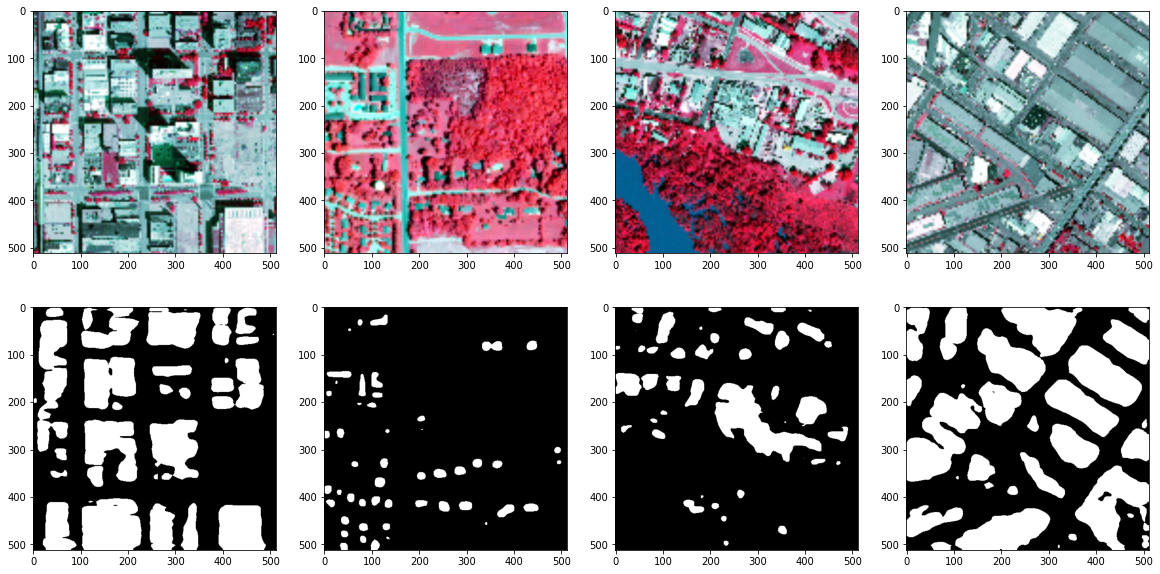

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
fig, ax = plt.subplots(2, 4, figsize = (20,10))
for i in range(len(predictions2)):
    metadata = predictions2[i].get(DataKeys.METADATA, None) or {}
    print(metadata)
    input = predictions2[i].get(DataKeys.INPUT, None).numpy().transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
    print(input.shape)
    ax[0,i].imshow(input)
    seg = predictions2[i].get(DataKeys.PREDS, None)
    temp= F.softmax(seg, dim=0)>0.5
    ax[1,i].imshow(np.reshape(temp[1,:,:].squeeze(), (512,512)), cmap = plt.cm.gray)
plt.show()

#  Debugging with vscode

The Visual Studio Code Remote - SSH extension allows you to open a remote folder on any remote machine, virtual machine, or container with a running SSH server and take full advantage of VS Code's feature set. Once connected to a server (Google Colab here), you can interact with files and folders anywhere on the remote filesystem:

![](https://code.visualstudio.com/assets/docs/remote/ssh/architecture-ssh.png)

More info here: https://code.visualstudio.com/docs/remote/ssh

In [ ]:
!pip -qqq install colab_ssh --upgrade
from colab_ssh import launch_ssh

You need to access your ngrok API key: https://dashboard.ngrok.com/get-started/your-authtoken. Note that the free account has a limited number of connections per time period.

and copy it below:

In [ ]:
ngrokToken = '<YOUR_GROK_TOKEN>'
launch_ssh(ngrokToken, password="password")

Note: your session will disconnect automatically after 15 minutes, you can keep a cell active with different solution, see https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting

In [ ]:
%%javascript
function ConnectButton(){
  console.log("Connect pushed");
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);

or simply run this cell:

In [ ]:
while True:pass

Then:
1. Install vscode: https://code.visualstudio.com/download
2. Install Remote SSH plugin: https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.vscode-remote-extensionpack
3. Go in `View ­> Command Palette`, type `Remote-SSH: Open SSH Config...`
4. Copy the text above, save `Ctrl+s`
5. Go in `View ­> Command Palette`, type `Remote-SSH: Connect to ...`
6. Select `google_colab_ssh`
7. Enter your password (the one above) when prompted
8. Go in `File ­> Open Folder`, type or select `/content`
9. In Colab: save the current notebook as a .py file (`File ­> Download > Download .py`)
10. Upload the .py into your colab workspace

In [ ]:
#@title
%%html
<iframe src="https://drive.google.com/file/d/1AGP1T21w1Ra6-WfhdrJYjjJxgF4qEW_n/preview" width="640" height="480" allow="autoplay"></iframe>